In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


2017-08-23
            prcp
date            
2016-08-23  0.00
2016-08-23   NaN
2016-08-23  1.79
2016-08-23  0.05
2016-08-23  0.15
...          ...
2017-08-22  0.00
2017-08-23  0.00
2017-08-23  0.00
2017-08-23  0.08
2017-08-23  0.45

[2230 rows x 1 columns]
There are 209 null values - dropping!


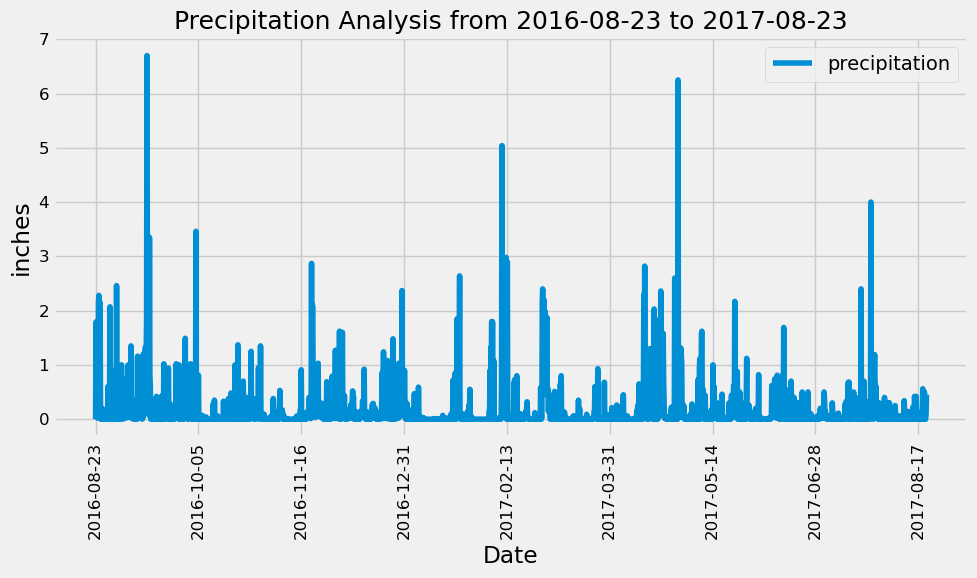

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
from sqlalchemy import inspect
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')  
# Starting from the most recent data point in the database. 
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent = (dt.datetime.strptime(most_recent, "%Y-%m-%d")).date()
print(most_recent)
# Calculate the date one year from the last date in data set.
last_one_year = most_recent - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
            filter((Measurement.date >= last_one_year)\
                    & (Measurement.date <= most_recent)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data).sort_values("date").set_index("date")

# Sort the dataframe by date
prcp_df.sort_values(by="date")
print(prcp_df)

# # Use Pandas Plotting with Matplotlib to plot the data
# rename prcp column
prcp_df.rename(columns={"prcp":"precipitation"}, inplace=True)
# check and drop null values
nv = prcp_df['precipitation'].isnull().sum()
print (f"There are {nv} null values - dropping!")

prcp_df.dropna(axis=0, how="any", inplace=True)
prcp_df.plot(figsize=(10,6), fontsize=12, rot=90)
plt.title(f"Precipitation Analysis from {last_one_year} to {most_recent}", fontsize=18)
plt.xlabel("Date")
plt.ylabel("inches")
plt.tight_layout()
plt.savefig("Images/prcp.png")
plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
# id is the primary key
stations_count = session.query(Station.id).count()
stations_count

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_st = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
             group_by(Measurement.station).\
             order_by(func.count(Measurement.id).desc()).first()
most_active_st

(54.0, 85.0, 71.66378066378067)

<function matplotlib.pyplot.show(close=None, block=None)>

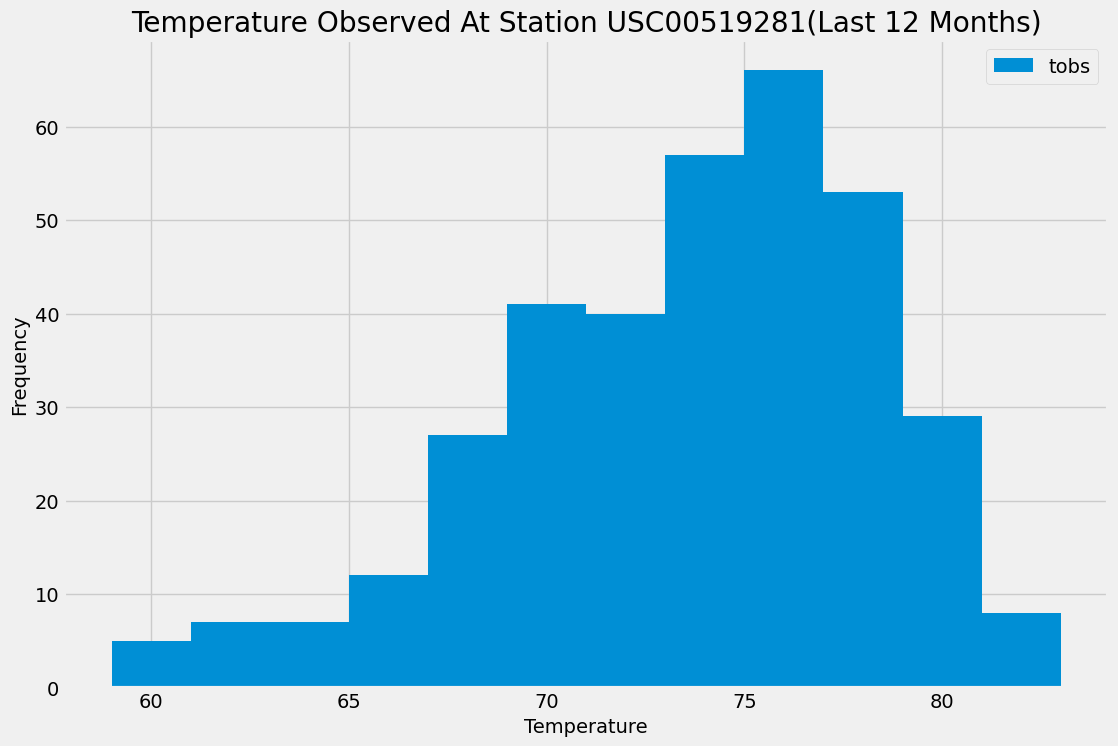

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obsv = session.query(Measurement.tobs).filter(Measurement.station =='USC00519281').\
             filter(Measurement.date >= last_one_year).all()
temp_obsv_df = pd.DataFrame(temp_obsv, columns=["tobs"])
temp_obsv_df.plot.hist(bins=12, title="Temperature Observed At Station USC00519281(Last 12 Months)", figsize=(12,8))
plt.xlabel('Temperature',fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.savefig("Images/tobs.png")
plt.show


# Close session

In [16]:
# Close Session
session.close()